# Quickstart Example with Synthetic RTB Simulation and Dataset (Continuous)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) on a synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simulation and Dataset consists of the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in the Appendix.

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our OPE implementations are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [5]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousTruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [6]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
# version
print(ofrl.__version__)

0.0.0


In [8]:
# set random state
random_state = 12345

In [9]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as number of clicks or conversions) within an episode under given budget constraints. We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the followings.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configurations, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

Then, Let's see how it works!

In [10]:
# setup environment
env = RTBEnv(random_state=random_state)

In [11]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [12]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [13]:
# state consists of the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


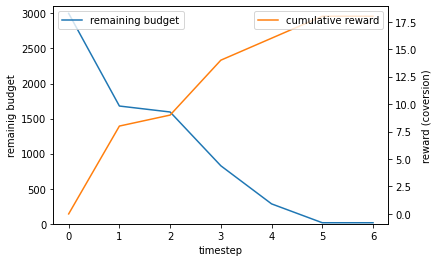

In [14]:
# let's visualize the transition of remaining budget and the cumulative reward
# our goal is to obtain a policy (i.e., agent) that maximizes the cumulative reward under budget constraints using RL.  
# for more visualization, please see the appendix.
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy run out the budget quickly.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward while meeting the given budget constraints.

For more about the environmental configurations and customization, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to the random policy, based on their on-policy policy value estimation.

In [15]:
# standardized environment for continuous actions
env = gym.make("RTBEnv-continuous-v0")
print(env.action_space)

Box(0.1, 10.0, (1,), float64)


In [16]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [17]:
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [17]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2022-11-24 04:13.00 [info     ] Directory is created at d3rlpy_logs/SAC_online_20221124041300
2022-11-24 04:13.00 [debug    ] Fitting action scaler...       action_scler=min_max
2022-11-24 04:13.00 [debug    ] Building model...
2022-11-24 04:13.00 [debug    ] Model has been built.
2022-11-24 04:13.00 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20221124041300/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-11-24 04:13.04 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20221124041300/model_1000.pt
2022-11-24 04:13.04 [info     ] SAC_online_20221124041300: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.001657743215560913, 'time_environment_step': 0.001623241662979126, 'time_step': 0.0033777382373809815, 'rollout_return': 0.0, 'evaluation': 0.0} step=1000
2022-11-24 04:15.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20221124041300/model_2000.pt
2022-11-24 04:15.34 [info     ] SAC_online_20221124041300: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0013964664936065674, 'time_environment_step': 0.0014573986530303955, 'time_sample_batch': 0.0004152514934539795, 'time_algorithm_update': 0.1457834072113037, 'temp_loss': -8.032622046470642, 'temp': 1.0494079979658126, 'critic_loss': 792.0752134475708, 'actor_loss': 5.279309185393155, 'time_step': 0.1491574146747589, 'rollout_return': 13.04225352112676, 'evaluation': 14.0} step=2000
202

In [17]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [18]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

Text(0, 0.5, 'episode reward')

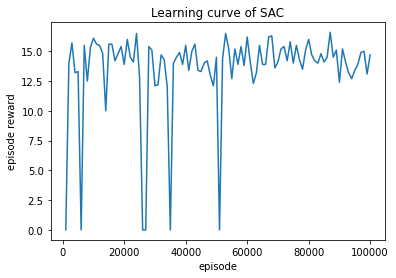

In [19]:
# may need more interactions to converge
log_path = sorted(glob("d3rlpy_logs/SAC_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of SAC")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [20]:
random = ContinuousRandomPolicy(
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

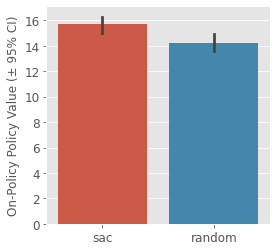

In [21]:
# compare the performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, random],
    policy_names=["sac", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [22]:
# on-policy policy value of the sac policy
# slightly improves that of the random policy
sac_performance = calc_on_policy_policy_value(env, sac, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (sac_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.08212560386473426


Note that, we provide the following functions for online evaluation of the policy performance under `ofrl.ope.online`.

(Statistics)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(Visualization)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. Synthetic Dataset Generation
In the previous section, we saw how we can interact with the environment *online* using a synthetic simulator.  
Though simulation is a good starting point for training an agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in real-world implementation.  
Therefore, we introduce alternative learning protocol, Offline RL, which aims at training a new policy using only offline logged data.

We prepare an easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL leveraging logged data.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `maximum_step_per_episode`: Maximum number of timesteps in an episode.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `action_keys`: Name of the action variable at each dimension.
- `state_keys`: Name of the state variable at each dimension.
- `info_keys`: Dictionary containing of key and the type of info components.
- `random_state`: Random state.

In [23]:
behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [24]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
    random_state=random_state,
)

In [25]:
# collect logged data by the behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_episodes(n_trajectories=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.44940540e-01, ...,
         1.66114895e-01, 2.00000000e+00, 3.10620929e+00],
        [1.00000000e+00, 1.79800000e+03, 4.00666667e-01, ...,
         1.00000000e+00, 9.00000000e+00, 9.52454525e+00],
        [2.00000000e+00, 1.25800000e+03, 3.00333704e-01, ...,
         8.35897436e-01, 2.00000000e+00, 1.31385945e+00],
        ...,
        [4.00000000e+00, 5.27000000e+02, 6.27034678e-01, ...,
         9.60199005e-01, 5.00000000e+00, 1.76450741e+00],
        [5.00000000e+00, 8.00000000e+00, 9.84819734e-01, ...,
         7.86458333e-01, 4.00000000e+00, 1.32477268e+00],
        [6.00000

In [27]:
with open("logs/dataset_continuous.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [25]:
with open("logs/dataset_continuous.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

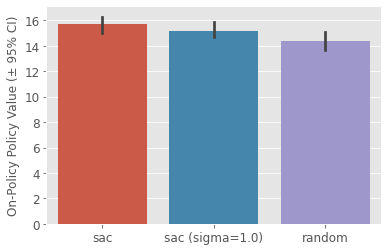

In [26]:
# compare the policy performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, random],
    policy_names=["sac", "sac (sigma=1.0)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [27]:
# let's see some statistics of the logged dataset
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.194803,175.390779,89.097314,8.908414,2.230386,0.505120,0.074132,0.151308
std,3.501734,182.112056,84.502003,9.126745,3.048590,0.404500,0.078599,0.190146
min,0.000037,4.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.660007,38.935459,6.000000,0.000000,0.000000,0.064378,0.000000,0.000000
50%,1.398543,79.479992,60.000000,6.000000,1.000000,0.489052,0.082474,0.086956
75%,7.423930,393.594124,180.000000,17.000000,4.000000,0.991238,0.111111,0.260869
max,10.174922,547.617021,290.000000,47.000000,20.000000,1.000000,0.999995,0.999998


For more about the data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of offline RL algorithms.

In [28]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL as ContinuousCQL
from d3rlpy.ope import FQE as ContinuousFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [29]:
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=False,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [30]:
# Use Conservative Q-Learning policy
cql = ContinuousCQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [30]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env_),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

2022-12-03 08:54.47 [debug    ] RandomIterator is selected.
2022-12-03 08:54.47 [info     ] Directory is created at d3rlpy_logs/CQL_20221203085447
2022-12-03 08:54.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-12-03 08:54.47 [debug    ] Building models...
2022-12-03 08:54.47 [debug    ] Models have been built.
2022-12-03 08:54.47 [info     ] Parameters are saved to d3rlpy_logs/CQL_20221203085447/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-12-03 09:02.22 [info     ] CQL_20221203085447: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0014659331560134888, 'time_algorithm_update': 0.04264785089492798, 'temp_loss': -5.1746882044196125, 'temp': 1.4102665637493133, 'alpha_loss': -13.795449819278717, 'alpha': 1.7720078201651572, 'critic_loss': 33.625301666545866, 'actor_loss': 5.53770480082091, 'time_step': 0.0451060230255127, 'environment': 14.3} step=10000
2022-12-03 09:02.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20221203085447/model_10000.pt


[(1,
  {'time_sample_batch': 0.0014659331560134888,
   'time_algorithm_update': 0.04264785089492798,
   'temp_loss': -5.1746882044196125,
   'temp': 1.4102665637493133,
   'alpha_loss': -13.795449819278717,
   'alpha': 1.7720078201651572,
   'critic_loss': 33.625301666545866,
   'actor_loss': 5.53770480082091,
   'time_step': 0.0451060230255127,
   'environment': 14.3})]

In [35]:
# save model
cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [31]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_continuous.pt")

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

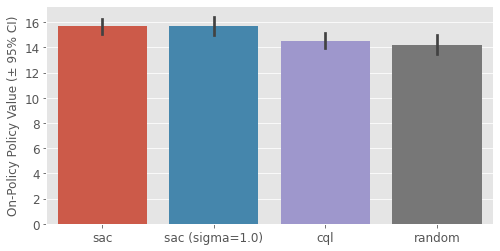

In [32]:
# compare the policy performance online
# wow, offline algorithm outperforms the online algorithm.
# even though it requires no interaction with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, cql, random],
    policy_names=["sac", "sac (sigma=1.0)", "cql", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of a learned policy via online interaction (aka A/B tests).  
However, it could be risky in practice, because the policy may perform poorly in an online environment.  
To tackle this issue, we aim at evaluating the performance of a policy offline, to gain some prior knowledge on how the agent works in the environment.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [33]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
from ofrl.policy import ContinuousEvalHead

In [34]:
# define evaluation policies (should be deterministic policy)
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
evaluation_policies = [cql_, sac_]

In [35]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=logged_dataset["state"].min(axis=0),
        maximum=logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
)

In [38]:
input_dict = prep.obtain_whole_inputs(
    logged_dataset=logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-01-04 21:02.26 [debug    ] RoundIterator is selected.
2023-01-04 21:02.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230104210226
2023-01-04 21:02.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-04 21:02.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-04 21:02.26 [debug    ] Building models...
2023-01-04 21:02.26 [debug    ] Models have been built.
2023-01-04 21:02.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230104210226/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-04 21:02.27 [info     ] FQE_20230104210226: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001436645644051688, 'time_algorithm_update': 0.0017119179453168596, 'loss': 21.928609319414413, 'time_step': 0.001922520569392613} step=700
2023-01-04 21:02.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230104210226/model_700.pt
2023-01-04 21:02.27 [debug    ] RoundIterator is selected.
2023-01-04 21:02.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230104210227
2023-01-04 21:02.27 [debug    ] Fitting scaler...              scaler=min_max
2023-01-04 21:02.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-04 21:02.27 [debug    ] Building models...
2023-01-04 21:02.27 [debug    ] Models have been built.
2023-01-04 21:02.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230104210227/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-04 21:02.29 [info     ] FQE_20230104210227: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001464782442365374, 'time_algorithm_update': 0.0016583139555794851, 'loss': 16.08958100931985, 'time_step': 0.0018663297380719867} step=700
2023-01-04 21:02.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230104210227/model_700.pt


[collect input data]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
with open("logs/ope_input_dict_continuous.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [36]:
with open("logs/ope_input_dict_continuous.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [37]:
input_dict

{'cql': {'evaluation_policy_action_dist': None,
  'evaluation_policy_action': array([[9.441403  ],
         [4.6896276 ],
         [4.188139  ],
         ...,
         [3.8834045 ],
         [3.9756644 ],
         [0.54805344]], dtype=float32),
  'state_action_value_prediction': array([[4.22544622, 4.43367815],
         [4.3877387 , 4.56757402],
         [3.33394599, 3.31908059],
         ...,
         [3.58541656, 3.61672044],
         [3.43254972, 3.52378297],
         [2.35033607, 2.35632515]]),
  'initial_state_value_prediction': array([4.43367815, 3.64424229, 4.51413965, ..., 4.55546713, 4.05965567,
         4.56462765]),
  'state_action_marginal_importance_weight': None,
  'state_marginal_importance_weight': None,
  'on_policy_policy_value': array([ 8.,  9., 10., 16., 14., 11., 16., 19., 12., 14., 26., 13., 12.,
          8., 14., 15., 14., 19., 11., 13., 10., 16., 16.,  8., 14., 13.,
         18., 16., 13., 13., 16., 11., 10., 14., 12., 18., 17., 13., 14.,
          9., 26., 12.

In [38]:
ope = OPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [39]:
# performance estimation by ope
# takes time to compute (about 15min)
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [43]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy  1.449000e+01           1.000000e+00
 dm         4.170207e+00           2.877990e-01
 tis        1.755035e-16           1.211204e-17
 pdis       6.766447e+00           4.669736e-01
 dr         1.041651e+01           7.188760e-01
 sntis      1.755035e-06           1.211204e-07
 snpdis     1.802106e+01           1.243689e+00
 sndr       2.232849e+01           1.540959e+00,
 'sac':            policy_value  relative_policy_value
 on_policy     15.680000               1.000000
 dm             2.122047               0.135335
 tis           22.021625               1.404440
 pdis          11.320470               0.721969
 dr            10.887521               0.694357
 sntis         15.919191               1.015255
 snpdis        14.803016               0.944070
 sndr          14.798250               0.943766}

In [44]:
# estimated confidence intervals of the policy performance
policy_value_interval_df_dict

{'cql':                    mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  1.440890e+01      1.366000e+01      1.508575e+01
 dm         4.170282e+00      4.160672e+00      4.179283e+00
 tis        1.806081e-16      3.237308e-17      3.121999e-16
 pdis       6.915471e+00      5.335368e+00      9.495728e+00
 dr         1.047924e+01      9.722306e+00      1.169199e+01
 sntis      1.806081e-06      3.237307e-07      3.121999e-06
 snpdis     1.848540e+01      8.900296e+00      3.180867e+01
 sndr       2.275879e+01      1.311782e+01      3.631339e+01,
 'sac':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  15.604500         14.894250         16.276250
 dm          2.122175          2.118715          2.126469
 tis        21.866471         20.102099         23.702495
 pdis       11.321800         11.063772         11.609012
 dr         10.906730         10.718083         11.178261
 sntis      15.807032         14.531586         17.134273
 snpdis     14.804989         

## 4. Evaluation of OPE methods
Now, we evaluate how well the ope estimators estimated the policy value.

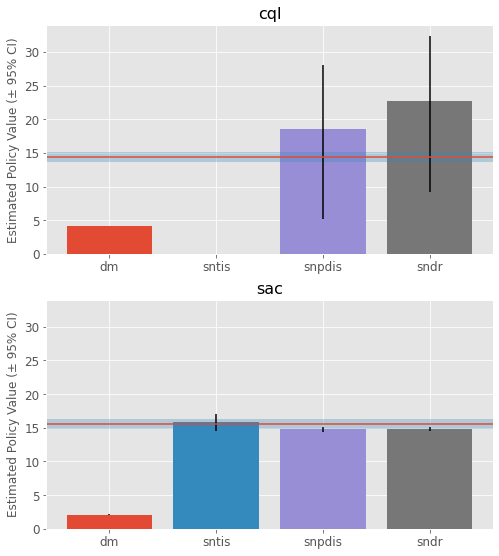

In [45]:
# we can visualize and compare the ope result
# it seems many offline metrics underestimate the policy value
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=True,
)

In [46]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,sac
dm,106.498129,183.818080
tis,209.960100,40.216210
pdis,59.653267,19.005499
dr,16.593293,22.967853
sntis,209.960049,0.057212
snpdis,12.468374,0.769101
sndr,61.441915,0.777482


For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb). 

For more advanced OPE estimators (e.g., state(-action) marginal estimators and double reinforcement learning), please refer to [examples/quickstart/rtb_synthetic_continuous_zoo.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_zoo.ipynb). 

For examples regarding the discrete action space, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

## Reference

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.